In [1]:
# Data Handling
import numpy as np
import pandas as pd
import h5py
from torch.utils.data import DataLoader, TensorDataset

# Machine Learning & Deep Learning
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd

# Neuroimaging
import nibabel as nib  # For loading NIfTI files
from nilearn.connectome import ConnectivityMeasure  # For connectivity matrices

# Data Preprocessing & Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

# LOADING THE DATA

In [2]:
file_path = "Data_ML/SC_FC_dataset_filtered_68x68.h5"

In [3]:
with h5py.File(file_path, "r") as f:
        # Load data for CTRL and SCHZ
    ctrl_data = f["FC_correlation"]["ctrl"][:]  # Load control group data
    schz_data = f["FC_correlation"]["schz"][:]  # Load schizophrenia group data

ctrl_tensor = torch.tensor(ctrl_data, dtype=torch.float32)
schz_tensor = torch.tensor(schz_data, dtype=torch.float32)


ctrl_data = (ctrl_data - np.min(ctrl_data)) / (np.max(ctrl_data) - np.min(ctrl_data))  # Normalize to [0,1]
ctrl_data = 2 * ctrl_data - 1  # Normalize to [-1,1]
ctrl_tensor = torch.tensor(ctrl_data, dtype=torch.float32).unsqueeze(1)  # Add channel dimension

schz_data = (schz_data - np.min(schz_data)) / (np.max(schz_data) - np.min(schz_data))  
schz_data = 2 * schz_data - 1 
schz_tensor = torch.tensor(schz_data, dtype=torch.float32).unsqueeze(1) 

# Use only CTRL data for training GAN
train_data = ctrl_tensor
batch_size = 32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Method 1: Using GANs

# A. Conventional GAN

**i. Generator**

In [ ]:
class Generator_GAN(nn.Module):
    def __init__(self, latent_dim):
        super(Generator_GAN, self).__init__()
        self.model =  nn.Sequential(
            nn.Linear(latent_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Linear(1024, 68 * 68),
            nn.Tanh()  # Output in range [-1; 1]
        )
    def forward(self, z):
        return self.model(z).view(-1, 1, 68, 68)

**ii. Discriminator**

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(68 * 68, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1),
            nn.Sigmoid()  # Output probability of being real
        )

    def forward(self, x):
        return self.model(x.view(-1, 68 * 68))

**iii. Training loop**

In [6]:
# Hyperparameters
latent_dim = 100
lr = 0.0002
epochs = 5000

# Initialize models
generator = Generator_GAN(latent_dim)
discriminator = Discriminator()

# Loss & Optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

# Training Loop
for epoch in range(epochs):
    for real_data in train_loader:
        real_data = real_data.view(-1, 68 * 68)  # Flatten
        batch_size = real_data.size(0)

        # Generate fake data
        z = torch.randn(batch_size, latent_dim)
        fake_data = generator(z)

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_data), torch.ones(batch_size, 1))  # Real -> 1
        fake_loss = criterion(discriminator(fake_data.detach()), torch.zeros(batch_size, 1))  # Fake -> 0
        loss_D = real_loss + fake_loss
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        loss_G = criterion(discriminator(fake_data), torch.ones(batch_size, 1))  # Fool Discriminator
        loss_G.backward()
        optimizer_G.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss_D={loss_D.item()}, Loss_G={loss_G.item()}")

Epoch 0: Loss_D=1.373732328414917, Loss_G=0.7469592690467834
Epoch 500: Loss_D=0.7628512382507324, Loss_G=1.3907051086425781
Epoch 1000: Loss_D=0.49792295694351196, Loss_G=3.6232309341430664
Epoch 1500: Loss_D=0.18750688433647156, Loss_G=5.288475513458252
Epoch 2000: Loss_D=0.12797431647777557, Loss_G=3.549445152282715
Epoch 2500: Loss_D=0.17984791100025177, Loss_G=3.3206348419189453
Epoch 3000: Loss_D=0.16938844323158264, Loss_G=3.4433040618896484
Epoch 3500: Loss_D=1.7691304683685303, Loss_G=56.572261810302734
Epoch 4000: Loss_D=1.768137812614441, Loss_G=57.127437591552734
Epoch 4500: Loss_D=1.7668838500976562, Loss_G=56.94663619995117


**iv. Generating and plotting new samples**

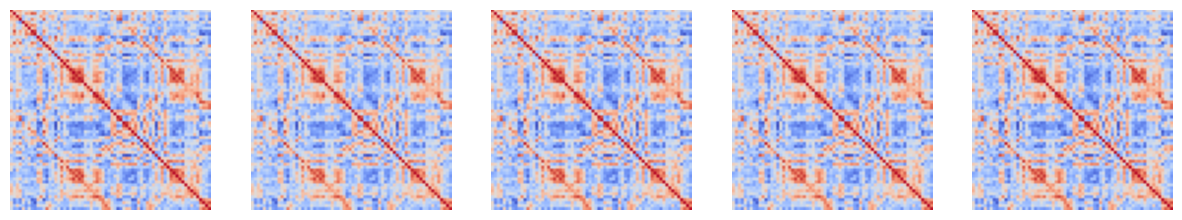

In [7]:
# Generate new samples
with torch.no_grad():
    z = torch.randn(5, latent_dim)  # Generate 5 fake connectomes
    fake_connectomes = generator(z).cpu().numpy()

# Visualize
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for i in range(5):
    axes[i].imshow(fake_connectomes[i, 0], cmap="coolwarm")
    axes[i].axis("off")
plt.show()


# B. Gradient penalty Wasserstein GAN (GP-WAN)

**i. Generator**

In [8]:
class Generator_WGAN(nn.Module):
    def __init__(self, latent_dim, output_shape=(68, 68)):
        super(Generator_WGAN, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, np.prod(output_shape)),
            nn.Tanh()  # Output scaled between -1 and 1
        )
        self.output_shape = output_shape

    def forward(self, z):
        out = self.model(z)
        return out.view(-1, *self.output_shape)

**ii. Critic (instead of discriminator)**

In [9]:
class Critic(nn.Module):
    def __init__(self, input_shape=(68, 68)):
        super(Critic, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(np.prod(input_shape), 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        return self.model(x)


**iii. Gradient penalty**

Computing **gradient penalty** to avoid weight clipping (which is used for usual WGAN) : weight clipping forces parameters into a small range, such that the Critic becomes less expressive and underfits. This is especially problematic when working with high-dimensional data. In contrast, WGAN-GP enforces the Lipschitz constraint by penalizing gradients that deviate from 1. This removes the problems of weight clipping and allows a more more stable training process, allowing WGAN-GP to generate higher-quality samples and to converge faster. By choosing WGAN-GP, Adam can be used as an optimizer.

In [10]:
def compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp=10):
    batch_size = min(real_samples.size(0), fake_samples.size(0)) # Ensure samples are the same size

    real_samples = real_samples[:batch_size]
    fake_samples = fake_samples[:batch_size]

    alpha = torch.rand(batch_size, 1, 1).to(real_samples.device)  # Match batch size
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)

    critic_interpolates = critic(interpolates)

    gradients = autograd.grad(
        outputs=critic_interpolates,
        inputs=interpolates,
        grad_outputs=torch.ones_like(critic_interpolates),
        create_graph=True, retain_graph=True
    )[0]

    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * lambda_gp
    return gradient_penalty


**Training WGAN-GP**

In [11]:
latent_dim = 100  # Dimensionality of latent space
generator = Generator_WGAN(latent_dim).cpu()
critic = Critic().cpu()

optimizer_G = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.5, 0.9))
optimizer_C = optim.Adam(critic.parameters(), lr=1e-4, betas=(0.5, 0.9))

In [22]:
n_critic = 5  # Train the Critic 5 times per Generator step
num_epochs = 500 
lambda_gp = 10 

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        real_samples = data[0]
        real_samples = real_samples.cpu()

        for _ in range(n_critic):
            optimizer_C.zero_grad()

            # Generate fake samples
            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            
            loss_critic = critic(fake_samples).mean() - critic(real_samples).mean()
            gradient_penalty = compute_gradient_penalty(critic, real_samples, fake_samples, lambda_gp)

            total_loss_C = loss_critic + gradient_penalty
            total_loss_C.backward()
            optimizer_C.step()

        # Train Generator once per loop
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            z = torch.randn(batch_size, latent_dim).cpu()
            fake_samples = generator(z)

            loss_generator = -critic(fake_samples).mean()
            loss_generator.backward()
            optimizer_G.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | Critic Loss: {total_loss_C.item():.4f} | Generator Loss: {loss_generator.item():.4f}")

Epoch [1/500] | Critic Loss: 9.1020 | Generator Loss: 0.2075
Epoch [11/500] | Critic Loss: -19.9141 | Generator Loss: 2.5223
Epoch [21/500] | Critic Loss: -65.1965 | Generator Loss: -12.7572
Epoch [31/500] | Critic Loss: -63.2682 | Generator Loss: -69.4298
Epoch [41/500] | Critic Loss: -33.4085 | Generator Loss: -84.1831
Epoch [51/500] | Critic Loss: -25.7165 | Generator Loss: -26.4620
Epoch [61/500] | Critic Loss: -32.8375 | Generator Loss: -59.9612
Epoch [71/500] | Critic Loss: -26.4368 | Generator Loss: -63.9847
Epoch [81/500] | Critic Loss: -35.6956 | Generator Loss: -15.6254
Epoch [91/500] | Critic Loss: -8.5591 | Generator Loss: -45.1664
Epoch [101/500] | Critic Loss: -62.4084 | Generator Loss: -56.3585
Epoch [111/500] | Critic Loss: -19.1429 | Generator Loss: -41.6577
Epoch [121/500] | Critic Loss: -8.1950 | Generator Loss: -65.5290
Epoch [131/500] | Critic Loss: -34.1630 | Generator Loss: -43.9954
Epoch [141/500] | Critic Loss: -46.3077 | Generator Loss: 26.1228
Epoch [151/500]

**Generate Augmented Connectomes**

In [24]:
# Generate new samples
generator.eval()
with torch.no_grad():
    z = torch.randn(5, latent_dim).cpu()
    generated_connectomes = generator(z).cpu().numpy()
z
print("Generated Connectomes Shape:", generated_connectomes.shape)

Generated Connectomes Shape: (5, 68, 68)


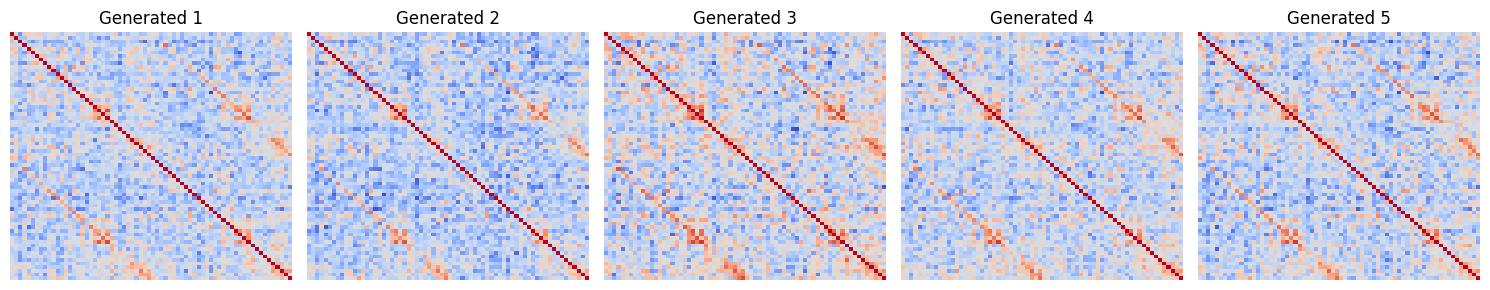

In [25]:
# Plot the first 5 generated connectomes
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    sns.heatmap(generated_connectomes[i], cmap="coolwarm", ax=axes[i], cbar=False)
    axes[i].set_title(f"Generated {i+1}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# C. VAE-GAN

**i. Encoder Network (VAE)**

In [13]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3_mu = nn.Linear(256, latent_dim)
        self.fc3_logvar = nn.Linear(256, latent_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        mu = self.fc3_mu(x)
        logvar = self.fc3_logvar(x)
        return mu, logvar


**ii. Decoder Network (VAE & GAN Generator)**

In [14]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, output_dim)
    
    def forward(self, z):
        z = torch.relu(self.fc1(z))
        z = torch.relu(self.fc2(z))
        return torch.tanh(self.fc3(z))  # Output in range [-1, 1]

**iii. Discriminator Network (GAN)**

In [15]:
class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.sigmoid(self.fc3(x))  # Probability of being real

**VAE-GAN Training Loop**

In [16]:
def train_vae_gan(encoder, decoder, discriminator, dataloader, optimizer_EG, optimizer_D, epochs=100, lambda_gp=0.1):
    for epoch in range(epochs):
        for data in dataloader:
            real_data = data[0].view(-1, 68 * 68)  # Flatten the data
            batch_size = real_data.size(0)
            
            # ===== Train Discriminator =====
            optimizer_D.zero_grad()
            z = torch.randn(batch_size, latent_dim)
            fake_data = decoder(z)

            real_labels = torch.ones(batch_size, 1)
            fake_labels = torch.zeros(batch_size, 1)

            real_loss = nn.BCELoss()(discriminator(real_data), real_labels)
            fake_loss = nn.BCELoss()(discriminator(fake_data.detach()), fake_labels)
            loss_D = real_loss + fake_loss
            loss_D.backward()
            optimizer_D.step()

            # Train Encoder-Decoder
            optimizer_EG.zero_grad()

            # VAE Loss: Reconstruction + KL Divergence
            mu, logvar = encoder(real_data)
            std = torch.exp(0.5 * logvar)
            qz = torch.normal(mu, std)
            recon_data = decoder(qz)

            recon_loss = nn.MSELoss()(recon_data, real_data)
            kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
            vae_loss = recon_loss + kl_loss

            # GAN Loss (Fooling the Discriminator)
            gen_loss = nn.BCELoss()(discriminator(recon_data), real_labels)
            total_loss = vae_loss + lambda_gp * gen_loss
            total_loss.backward()
            optimizer_EG.step()

        print(f"Epoch [{epoch}/{epochs}], VAE Loss: {vae_loss.item()}, GAN Loss: {gen_loss.item()}")

latent_dim = 100
input_dim = 68 * 68
output_dim = input_dim  # Same as input size for reconstruction
epochs = 100

encoder = Encoder(input_dim, latent_dim)
decoder = Decoder(latent_dim, output_dim)
discriminator = Discriminator(output_dim)

optimizer_EG = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


train_vae_gan(encoder, decoder, discriminator, train_loader, optimizer_EG, optimizer_D, epochs)


Epoch [0/100], VAE Loss: 0.2782008647918701, GAN Loss: 0.7432246208190918
Epoch [1/100], VAE Loss: 0.25569337606430054, GAN Loss: 0.7465898394584656
Epoch [2/100], VAE Loss: 0.21682971715927124, GAN Loss: 0.7778220772743225
Epoch [3/100], VAE Loss: 0.19002637267112732, GAN Loss: 0.7633686661720276
Epoch [4/100], VAE Loss: 0.15607640147209167, GAN Loss: 0.7928837537765503
Epoch [5/100], VAE Loss: 0.14576664566993713, GAN Loss: 0.7841898202896118
Epoch [6/100], VAE Loss: 0.14365610480308533, GAN Loss: 0.8107436895370483
Epoch [7/100], VAE Loss: 0.15736883878707886, GAN Loss: 0.822414755821228
Epoch [8/100], VAE Loss: 0.17898577451705933, GAN Loss: 0.8474822044372559
Epoch [9/100], VAE Loss: 0.13290748000144958, GAN Loss: 0.7958759069442749
Epoch [10/100], VAE Loss: 0.19141994416713715, GAN Loss: 0.8307109475135803
Epoch [11/100], VAE Loss: 0.15681390464305878, GAN Loss: 0.7685536742210388
Epoch [12/100], VAE Loss: 0.13611188530921936, GAN Loss: 0.7722595930099487
Epoch [13/100], VAE Loss

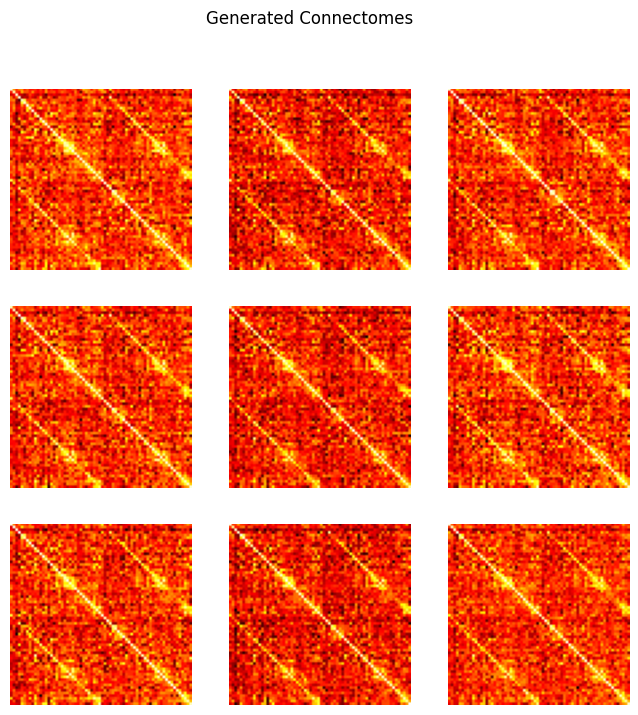

In [21]:
z = torch.randn(9, latent_dim)  # Sample random latent vectors
generated_images = decoder(z).detach().cpu().numpy()  # Generate images
generated_images = np.reshape(generated_images, (-1, 68, 68))  # Reshape


fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(generated_images[i], cmap="hot")  # Use 'hot' colormap for connectivity
    ax.axis("off")
plt.suptitle("Generated Connectomes")
plt.show()

# Method 2 : Using diffusion models